# Initialize

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from model import ImageMamba, ModelArgs  # For MAMBA
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import datetime
import torch.optim as optim

In [3]:
from tqdm import tqdm

import keras
from tensorflow import keras
from keras.datasets import cifar10
from __future__ import print_function
from keras.models import Sequential
from keras.models import save_model, load_model
from keras.layers import Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

import keras.backend as K
K.clear_session()

# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
# from model import Mamba, ModelArgs  # Import your custom Mamba implementation
# Assuming the model classes are defined in `model.py`
from model import ImageMamba, ModelArgs

In [4]:
# Load CIFAR-10 data
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

# Reshape and preprocess the CIFAR-10 dataset for PyTorch models
X_train = X_train.transpose(0, 3, 1, 2)  # Shape: (batch_size, channels, height, width)
X_test = X_test.transpose(0, 3, 1, 2)

# Convert data to float and normalize pixel values in the range [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Convert the train/test data into PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.long)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.long)

# Your existing train loader code
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Add test loader
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)  # Note: shuffle=False for test data

# Functions

In [14]:
class AttackModel(nn.Module):
    def __init__(self, num_classes=10):
        super(AttackModel, self).__init__()
        self.input_size = num_classes * 2  # logits + probabilities
        
        # Deeper architecture with batch normalization
        self.classifier = nn.Sequential(
            nn.Linear(self.input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(32, 2)
        )
        
        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(0)
        return self.classifier(x)

class MembershipInferenceAttack:
    def __init__(self, target_model, device='cpu'):
        self.target_model = target_model
        self.attack_model = AttackModel().to(device)
        self.device = device
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.attack_model.parameters(), lr=0.001)
    
    def prepare_attack_data(self, train_loader, test_loader):
        attack_inputs = []
        attack_labels = []
        
        self.target_model.eval()
        with torch.no_grad():
            print("Processing training data...")
            for data, labels in train_loader:
                data = data.to(self.device)
                outputs = self.target_model(data)
                if isinstance(outputs, tuple):
                    logits, probabilities = outputs
                else:
                    logits = outputs
                    probabilities = torch.softmax(logits, dim=1)
                
                features = torch.cat([logits, probabilities], dim=1)
                attack_inputs.append(features.cpu())
                attack_labels.extend([1] * logits.size(0))
            
            print("\nProcessing test data...")
            for data, labels in test_loader:
                data = data.to(self.device)
                outputs = self.target_model(data)
                if isinstance(outputs, tuple):
                    logits, probabilities = outputs
                else:
                    logits = outputs
                    probabilities = torch.softmax(logits, dim=1)
                
                features = torch.cat([logits, probabilities], dim=1)
                attack_inputs.append(features.cpu())
                attack_labels.extend([0] * logits.size(0))
        
        attack_inputs = torch.cat(attack_inputs, dim=0)
        attack_labels = torch.tensor(attack_labels, dtype=torch.long)
        return attack_inputs, attack_labels

    def train_attack(self, train_loader, test_loader, epochs=10):
        print("Preparing attack data...")
        X, y = self.prepare_attack_data(train_loader, test_loader)
        
        # Create balanced dataset
        member_mask = y == 1
        non_member_mask = y == 0
        
        member_samples = X[member_mask]
        non_member_samples = X[non_member_mask]
        
        min_samples = min(len(member_samples), len(non_member_samples))
        
        if len(member_samples) > min_samples:
            indices = torch.randperm(len(member_samples))[:min_samples]
            member_samples = member_samples[indices]
        if len(non_member_samples) > min_samples:
            indices = torch.randperm(len(non_member_samples))[:min_samples]
            non_member_samples = non_member_samples[indices]
        
        X_balanced = torch.cat([member_samples, non_member_samples])
        y_balanced = torch.cat([torch.ones(min_samples), torch.zeros(min_samples)]).long()
        
        # Split into training and validation
        indices = torch.randperm(len(X_balanced))
        split = int(0.8 * len(indices))
        train_indices = indices[:split]
        val_indices = indices[split:]
        
        train_data = torch.utils.data.TensorDataset(
            X_balanced[train_indices],
            y_balanced[train_indices]
        )
        val_data = torch.utils.data.TensorDataset(
            X_balanced[val_indices],
            y_balanced[val_indices]
        )
        
        train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
        val_loader = DataLoader(val_data, batch_size=64)
        
        train_accs = []
        val_accs = []
        best_val_acc = 0
        epochs_without_improvement = 0
        
        print("\nTraining attack model with extended epochs...")
        for epoch in range(epochs):
            # Training phase
            self.attack_model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0
            
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                
                self.optimizer.zero_grad()
                outputs = self.attack_model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                
                train_loss += loss.item()
                _, predicted = outputs.max(1)
                train_total += labels.size(0)
                train_correct += predicted.eq(labels).sum().item()
            
            train_acc = 100. * train_correct / train_total
            train_accs.append(train_acc)
            
            # Validation phase
            self.attack_model.eval()
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    outputs = self.attack_model(inputs)
                    _, predicted = outputs.max(1)
                    val_total += labels.size(0)
                    val_correct += predicted.eq(labels).sum().item()
            
            val_acc = 100. * val_correct / val_total
            val_accs.append(val_acc)
            
            print(f'Epoch {epoch+1:3d} | Train Loss: {train_loss/len(train_loader):.4f} | '
                  f'Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%')
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
            
            if epochs_without_improvement >= 5:
                print(f'\nEarly stopping at epoch {epoch+1} due to no improvement in validation accuracy')
                break
        
        return train_accs, val_accs

def evaluate_attack(attack_model, target_model, data_loader, is_member, device, num_samples=1000):
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    total = 0
    
    target_model.eval()
    attack_model.eval()
    
    with torch.no_grad():
        for data, _ in data_loader:
            if total >= num_samples:
                break
            
            data = data.to(device)
            outputs = target_model(data)
            if isinstance(outputs, tuple):
                logits, probabilities = outputs
            else:
                logits = outputs
                probabilities = torch.softmax(logits, dim=1)
            
            features = torch.cat([logits, probabilities], dim=1)
            attack_outputs = attack_model(features)
            predictions = (torch.softmax(attack_outputs, dim=1)[:, 1] > 0.5).long()
            
            # Calculate metrics based on membership status
            if is_member:
                true_positives += (predictions == 1).sum().item()
                false_negatives += (predictions == 0).sum().item()
            else:
                true_negatives += (predictions == 0).sum().item()
                false_positives += (predictions == 1).sum().item()
            
            total += data.size(0)
            if total >= num_samples:
                break
    
    # Calculate precision and recall for member identification
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    
    metrics = {
        'precision': precision,
        'recall': recall,
        'true_positives': true_positives,
        'false_positives': false_positives,
        'true_negatives': true_negatives,
        'false_negatives': false_negatives,
        'accuracy': (true_positives + true_negatives) / total if total > 0 else 0
    }
    
    return metrics

def run_extended_attack(model, train_loader, test_loader):
    device = torch.device('cpu')
    attack = MembershipInferenceAttack(model, device)
    train_accs, val_accs = attack.train_attack(train_loader, test_loader)
    
    print("\nEvaluating final attack performance...")
    train_metrics = evaluate_attack(attack.attack_model, model, train_loader, True, device)
    test_metrics = evaluate_attack(attack.attack_model, model, test_loader, False, device)
    
    print(f"\nFinal Attack Results:")
    print(f"Training Set Metrics:")
    print(f"- Accuracy: {train_metrics['accuracy']*100:.2f}%")
    print(f"- Precision: {train_metrics['precision']*100:.2f}%")
    print(f"- Recall: {train_metrics['recall']*100:.2f}%")
    
    print(f"\nTest Set Metrics:")
    print(f"- Accuracy: {test_metrics['accuracy']*100:.2f}%")
    print(f"- Precision: {test_metrics['precision']*100:.2f}%")
    print(f"- Recall: {test_metrics['recall']*100:.2f}%")
    
    overall_acc = (train_metrics['accuracy'] + test_metrics['accuracy']) / 2
    print(f"\nOverall attack accuracy: {overall_acc*100:.2f}%")
    
    return attack, train_accs, val_accs, train_metrics['accuracy'], test_metrics['accuracy']

def attack_checkpoint(epoch_num, model, train_loader, test_loader):
    print(f"\n{'='*50}")
    print(f"Analyzing model checkpoint from epoch {epoch_num}")
    print('='*50)

    if isinstance(model, ImageMamba):
        model_path = os.path.join('model_checkpoints_extended', f'mamba_model_epoch_{epoch_num}.pt')
    else:
        model_path = os.path.join('smaller_cnn_checkpoints', f'cnn_model_epoch_{epoch_num}.pt')
    saved_model = torch.load(model_path, map_location=torch.device('cpu'))
    model.load_state_dict(saved_model['model_state_dict'])
    device = torch.device('cpu')
    model = model.to(device)
    model.eval()
    
    attack, train_accs, val_accs, final_train_acc, final_test_acc = run_extended_attack(
        model, train_loader, test_loader)
    
    return {
        'epoch': epoch_num,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'final_train_acc': final_train_acc * 100,  # Convert to percentage
        'final_val_acc': final_test_acc * 100  # Convert to percentage
    }

def analyze_multiple_checkpoints(model, train_loader, test_loader, epochs=[50, 100, 150, 200, 250, 300, 350, 400]): 
    results = []
    
    for epoch in epochs:
        result = attack_checkpoint(epoch, model, train_loader, test_loader)
        results.append(result)
    
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Final accuracies for each checkpoint
    plt.subplot(2, 1, 1)
    epochs = [r['epoch'] for r in results]
    train_accs = [r['final_train_acc'] for r in results]
    val_accs = [r['final_val_acc'] for r in results]
    
    plt.plot(epochs, train_accs, 'b-o', label='Training Accuracy')
    plt.plot(epochs, val_accs, 'r-o', label='Validation Accuracy')
    plt.axhline(y=50, color='gray', linestyle='--', label='Random Guess (50%)')
    plt.xlabel('Training Epoch of Target Model')
    plt.ylabel('Attack Success Rate (%)')
    plt.title('Membership Inference Attack Success Rate vs Model Training Progress')
    plt.legend()
    plt.grid(True)
    
    # Plot 2: Attack training curves for each checkpoint
    plt.subplot(2, 1, 2)
    for result in results:
        epoch_num = result['epoch']
        epochs_x = range(1, len(result['train_accs']) + 1)
        plt.plot(epochs_x, result['train_accs'],
                label=f'Train (Epoch {epoch_num})',
                linestyle='-', alpha=0.7)
        plt.plot(epochs_x, result['val_accs'],
                label=f'Val (Epoch {epoch_num})',
                linestyle='--', alpha=0.7)
    
    plt.axhline(y=50, color='gray', linestyle='--', label='Random Guess (50%)')
    plt.xlabel('Attack Model Training Epoch')
    plt.ylabel('Attack Accuracy (%)')
    plt.title('Attack Model Training Progress for Different Checkpoints')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print("\nSummary of Results:")
    print("="*80)
    print(f"{'Checkpoint':^15} | {'Train Acc':^15} | {'Val Acc':^15} | {'Vulnerability':^25}")
    print("-"*80)
    
    for result in results:
        vulnerability = "Low"
        acc_diff = result['final_train_acc'] - result['final_val_acc']
        if acc_diff > 5 or result['final_train_acc'] > 55:
            vulnerability = "Moderate"
        if acc_diff > 10 or result['final_train_acc'] > 60:
            vulnerability = "High"
        
        print(f"Epoch {result['epoch']:^8} | "
              f"{result['final_train_acc']:^13.2f}% | "
              f"{result['final_val_acc']:^13.2f}% | "
              f"{vulnerability:^25}")
    
    return results

In [11]:
def load_metrics(model_type):
    """Load training metrics from JSON file for specified model type"""
    if model_type.lower() == 'mamba':
        metrics_path = os.path.join('model_checkpoints_extended', 'training_metrics.json')
    else:  # CNN
        metrics_path = os.path.join('cnn_checkpoints', 'training_metrics.json')
    
    if not os.path.exists(metrics_path):
        raise FileNotFoundError(f"Metrics file not found for {model_type} at {metrics_path}")
    
    with open(metrics_path, 'r') as f:
        return json.load(f)

def analyze_models(mamba_model, cnn_model, train_loader, test_loader, save_dir='comparison_plots'):
    """Analyze and compare MAMBA and CNN models with extended attack analysis"""
    os.makedirs(save_dir, exist_ok=True)
    
    # Load training metrics
    mamba_metrics = load_metrics('mamba')
    cnn_metrics = load_metrics('cnn')
    
    # Create figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))
    
    # 1. Model Performance Plot
    epochs = range(1, min(len(mamba_metrics['test_accuracies']), 
                         len(cnn_metrics['test_accuracies'])) + 1)
    
    ax1.plot(epochs, mamba_metrics['test_accuracies'], 'b-', label='MAMBA')
    ax1.plot(epochs, cnn_metrics['test_accuracies'], 'r-', label='CNN')
    ax1.set_title('Model Performance on CIFAR-10')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Test Accuracy (%)')
    ax1.legend()
    ax1.grid(True)
    
    # 2. Overfitting Analysis Plot
    mamba_overfit = [train - test for train, test in 
                     zip(mamba_metrics['train_accuracies'], mamba_metrics['test_accuracies'])]
    cnn_overfit = [train - test for train, test in 
                   zip(cnn_metrics['train_accuracies'], cnn_metrics['test_accuracies'])]
    
    ax2.plot(epochs, mamba_overfit, 'b-', label='MAMBA')
    ax2.plot(epochs, cnn_overfit, 'r-', label='CNN')
    ax2.set_title('Overfitting Analysis (Train-Test Accuracy Gap)')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy Gap (%)')
    ax2.legend()
    ax2.grid(True)
    
    # 3. Inference Attack Susceptibility
    # Run extended attacks at different checkpoints
    mamba_attack_results = []
    cnn_attack_results = []
    checkpoint_epochs = [50, 100, 150, 200, 250, 300, 350, 400]  # Adjust based on available checkpoints
    
    print("\nAnalyzing MAMBA checkpoints...")
    mamba_results = analyze_multiple_checkpoints(mamba_model, train_loader, test_loader, 
                                               epochs=checkpoint_epochs)
    
    print("\nAnalyzing CNN checkpoints...")
    cnn_results = analyze_multiple_checkpoints(cnn_model, train_loader, test_loader, 
                                             epochs=checkpoint_epochs)
    
    # Plot attack success rates
    mamba_epochs = [r['epoch'] for r in mamba_results]
    mamba_attack_acc = [(r['final_train_acc'] + r['final_val_acc'])/2 for r in mamba_results]
    
    cnn_epochs = [r['epoch'] for r in cnn_results]
    cnn_attack_acc = [(r['final_train_acc'] + r['final_val_acc'])/2 for r in cnn_results]
    
    ax3.plot(mamba_epochs, mamba_attack_acc, 'b-o', label='MAMBA')
    ax3.plot(cnn_epochs, cnn_attack_acc, 'r-o', label='CNN')
    ax3.axhline(y=50, color='gray', linestyle='--', label='Random Guess')
    ax3.set_title('Membership Inference Attack Success Rate')
    ax3.set_xlabel('Training Epochs')
    ax3.set_ylabel('Attack Success Rate (%)')
    ax3.legend()
    ax3.grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'model_analysis.png'))
    plt.show()
    
    # Print summary statistics
    print("\nModel Analysis Summary:")
    print("="*50)
    print("Final Test Accuracy:")
    print(f"MAMBA: {mamba_metrics['test_accuracies'][-1]:.2f}%")
    print(f"CNN: {cnn_metrics['test_accuracies'][-1]:.2f}%")
    
    print("\nFinal Overfitting Gap:")
    print(f"MAMBA: {mamba_overfit[-1]:.2f}%")
    print(f"CNN: {cnn_overfit[-1]:.2f}%")
    
    print("\nFinal Attack Success Rates:")
    print(f"MAMBA: {mamba_attack_acc[-1]:.2f}%")
    print(f"CNN: {cnn_attack_acc[-1]:.2f}%")
    
    return {
        'mamba_metrics': {
            'final_accuracy': mamba_metrics['test_accuracies'][-1],
            'overfitting_gap': mamba_overfit[-1],
            'attack_success': mamba_attack_acc[-1],
            'attack_results': mamba_results
        },
        'cnn_metrics': {
            'final_accuracy': cnn_metrics['test_accuracies'][-1],
            'overfitting_gap': cnn_overfit[-1],
            'attack_success': cnn_attack_acc[-1],
            'attack_results': cnn_results
        }
    }

def plot_model_comparisons(save_dir='comparison_plots'):
    """Plot comparison metrics between MAMBA and CNN models from saved metrics"""
    os.makedirs(save_dir, exist_ok=True)
    
    # Load metrics for both models
    mamba_metrics = load_metrics('mamba')
    cnn_metrics = load_metrics('cnn')
    
    # Create epochs array
    epochs = range(1, min(len(mamba_metrics['train_losses']), 
                         len(cnn_metrics['train_losses'])) + 1)
    
    # Create figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot Loss Comparison
    ax1.plot(epochs, mamba_metrics['train_losses'], 'b-', label='MAMBA Train')
    ax1.plot(epochs, mamba_metrics['test_losses'], 'b--', label='MAMBA Test')
    ax1.plot(epochs, cnn_metrics['train_losses'], 'r-', label='CNN Train')
    ax1.plot(epochs, cnn_metrics['test_losses'], 'r--', label='CNN Test')
    ax1.set_title('Loss Comparison')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot Accuracy Comparison
    ax2.plot(epochs, mamba_metrics['train_accuracies'], 'b-', label='MAMBA Train')
    ax2.plot(epochs, mamba_metrics['test_accuracies'], 'b--', label='MAMBA Test')
    ax2.plot(epochs, cnn_metrics['train_accuracies'], 'r-', label='CNN Train')
    ax2.plot(epochs, cnn_metrics['test_accuracies'], 'r--', label='CNN Test')
    ax2.set_title('Accuracy Comparison')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    # Plot Average Confidence Comparison
    ax3.plot(epochs, mamba_metrics['train_confidences'], 'b-', label='MAMBA Train')
    ax3.plot(epochs, mamba_metrics['test_confidences'], 'b--', label='MAMBA Test')
    ax3.plot(epochs, cnn_metrics['train_confidences'], 'r-', label='CNN Train')
    ax3.plot(epochs, cnn_metrics['test_confidences'], 'r--', label='CNN Test')
    ax3.set_title('Average Confidence Comparison')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Confidence')
    ax3.legend()
    ax3.grid(True)

    # Plot Final Confidence Distributions
    mamba_train_conf = mamba_metrics['epoch_train_confidences'][-1]
    mamba_test_conf = mamba_metrics['epoch_test_confidences'][-1]
    cnn_train_conf = cnn_metrics['epoch_train_confidences'][-1]
    cnn_test_conf = cnn_metrics['epoch_test_confidences'][-1]
    
    sns.kdeplot(data=mamba_train_conf, ax=ax4, label='MAMBA Train', color='blue')
    sns.kdeplot(data=mamba_test_conf, ax=ax4, label='MAMBA Test', color='blue', linestyle='--')
    sns.kdeplot(data=cnn_train_conf, ax=ax4, label='CNN Train', color='red')
    sns.kdeplot(data=cnn_test_conf, ax=ax4, label='CNN Test', color='red', linestyle='--')
    ax4.set_title('Final Epoch Confidence Distributions')
    ax4.set_xlabel('Confidence')
    ax4.set_ylabel('Density')
    ax4.legend()
    ax4.grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'model_comparisons.png'))
    plt.show()  # Display the plot
    plt.close()

def plot_inference_attack_susceptibility(save_dir='comparison_plots'):
    """Plot inference attack susceptibility comparison between models"""
    os.makedirs(save_dir, exist_ok=True)
    
    # Load metrics
    mamba_metrics = load_metrics('mamba')
    cnn_metrics = load_metrics('cnn')
    
    # Calculate confidence gaps for both models
    mamba_gaps = []
    cnn_gaps = []
    epochs = []
    
    min_epochs = min(len(mamba_metrics['train_confidences']), 
                    len(cnn_metrics['train_confidences']))
    
    for epoch in range(min_epochs):
        # MAMBA confidence gap
        mamba_train = np.mean(mamba_metrics['epoch_train_confidences'][epoch])
        mamba_test = np.mean(mamba_metrics['epoch_test_confidences'][epoch])
        mamba_gaps.append(mamba_train - mamba_test)
        
        # CNN confidence gap
        cnn_train = np.mean(cnn_metrics['epoch_train_confidences'][epoch])
        cnn_test = np.mean(cnn_metrics['epoch_test_confidences'][epoch])
        cnn_gaps.append(cnn_train - cnn_test)
        
        epochs.append(epoch + 1)
    
    # Create plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot confidence gaps over time
    ax1.plot(epochs, mamba_gaps, 'b-', label='MAMBA')
    ax1.plot(epochs, cnn_gaps, 'r-', label='CNN')
    ax1.set_title('Confidence Gap Evolution')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Confidence Gap (Train - Test)')
    ax1.legend()
    ax1.grid(True)
    
    # Plot statistical analysis
    # Calculate final statistics
    final_stats = {
        'mamba': {
            'mean_gap': np.mean(mamba_gaps[-10:]),  # Average of last 10 epochs
            'std_gap': np.std(mamba_gaps[-10:])
        },
        'cnn': {
            'mean_gap': np.mean(cnn_gaps[-10:]),
            'std_gap': np.std(cnn_gaps[-10:])
        }
    }
    
    # Plot final gap distributions
    sns.kdeplot(data=mamba_gaps[-100:], ax=ax2, label=f"MAMBA (μ={final_stats['mamba']['mean_gap']:.4f})", color='blue')
    sns.kdeplot(data=cnn_gaps[-100:], ax=ax2, label=f"CNN (μ={final_stats['cnn']['mean_gap']:.4f})", color='red')
    ax2.set_title('Confidence Gap Distribution (Last 100 Epochs)')
    ax2.set_xlabel('Confidence Gap')
    ax2.set_ylabel('Density')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'inference_attack_susceptibility.png'))
    plt.show()  # Display the plot
    plt.close()
    
    # Return statistics for analysis
    return final_stats

def generate_comparison_report(save_dir='comparison_plots'):
    """Generate comprehensive comparison report with plots and statistics"""
    # Create plots
    plot_model_comparisons(save_dir)
    final_stats = plot_inference_attack_susceptibility(save_dir)
    
    # Create report
    report = {
        'inference_attack_susceptibility': final_stats,
        'plots_generated': [
            'model_comparisons.png',
            'inference_attack_susceptibility.png'
        ],
        'timestamp': str(datetime.datetime.now())
    }
    
    # Save report
    with open(os.path.join(save_dir, 'comparison_report.json'), 'w') as f:
        json.dump(report, f, indent=4)
    
    return report

In [12]:
class SmallerComparableCNN(nn.Module):
    def __init__(self):
        super(SmallerComparableCNN, self).__init__()
        # Reduced initial channels and total layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Reduced from 64 to 32
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Reduced from 128 to 64
        self.bn2 = nn.BatchNorm2d(64)
        
        # Removed two conv layers to reduce parameters
        
        # Global average pooling and final dense layer
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 10)  # Changed input features to match last conv layer
        
    def forward(self, x):
        # First block
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        
        # Second block
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        
        # Global average pooling
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        
        # Final classification
        logits = self.fc(x)
        probabilities = F.softmax(logits, dim=-1)
        
        return logits, probabilities

# Initialize models
d_model = 64
n_layer = 4
num_classes = 10

model_args = ModelArgs(d_model=d_model, n_layer=n_layer, vocab_size=0)
mamba_model = ImageMamba(model_args, num_classes=num_classes)
smaller_cnn_model = SmallerComparableCNN()

# Load last checkpoints
mamba_checkpoint = os.path.join('model_checkpoints_extended', 'mamba_model_epoch_400.pt')
smaller_cnn_checkpoint = os.path.join('smaller_cnn_checkpoints', 'cnn_model_epoch_400.pt')

print(f"Loading MAMBA from {mamba_checkpoint}")
mamba_state = torch.load(mamba_checkpoint, map_location='cpu')
mamba_model.load_state_dict(mamba_state['model_state_dict'])

print(f"Loading CNN from {smaller_cnn_checkpoint}")
smaller_cnn_state = torch.load(smaller_cnn_checkpoint, map_location='cpu')
smaller_cnn_model.load_state_dict(smaller_cnn_state['model_state_dict'])

# Set models to evaluation mode
mamba_model.eval()
smaller_cnn_model.eval()

# Prepare data loaders
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Now ready to run the analysis
print("Models loaded successfully. Ready for analysis...")

Loading MAMBA from model_checkpoints_extended\mamba_model_epoch_400.pt


C:\Users\baris\AppData\Local\Temp\ipykernel_7488\747583779.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mamba_state = torch.load(mamba_checkpoint, map_location='cpu'

Loading CNN from smaller_cnn_checkpoints\cnn_model_epoch_400.pt


C:\Users\baris\AppData\Local\Temp\ipykernel_7488\747583779.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  smaller_cnn_state = torch.load(smaller_cnn_checkpoint, map_lo

Files already downloaded and verified
Files already downloaded and verified
Models loaded successfully. Ready for analysis...



Analyzing MAMBA checkpoints...

Analyzing model checkpoint from epoch 50


C:\Users\baris\AppData\Local\Temp\ipykernel_7488\4097793900.py:274: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_model = torch.load(model_path, map_location=torch.dev

Preparing attack data...
Processing training data...

Processing test data...

Training attack model with extended epochs...
Epoch   1 | Train Loss: 0.7233 | Train Acc: 49.69% | Val Acc: 49.67%
Epoch   2 | Train Loss: 0.7021 | Train Acc: 50.13% | Val Acc: 48.33%
Epoch   3 | Train Loss: 0.6987 | Train Acc: 50.28% | Val Acc: 48.20%
Epoch   4 | Train Loss: 0.6959 | Train Acc: 50.49% | Val Acc: 49.33%
Epoch   5 | Train Loss: 0.6946 | Train Acc: 50.99% | Val Acc: 49.48%
Epoch   6 | Train Loss: 0.6942 | Train Acc: 50.95% | Val Acc: 49.05%

Early stopping at epoch 6 due to no improvement in validation accuracy

Evaluating final attack performance...

Final Attack Results:
Training Set Metrics:
- Accuracy: 74.80%
- Precision: 100.00%
- Recall: 74.80%

Test Set Metrics:
- Accuracy: 33.11%
- Precision: 0.00%
- Recall: 0.00%

Overall attack accuracy: 53.96%

Analyzing model checkpoint from epoch 100
Preparing attack data...
Processing training data...

Processing test data...

Training attack mod

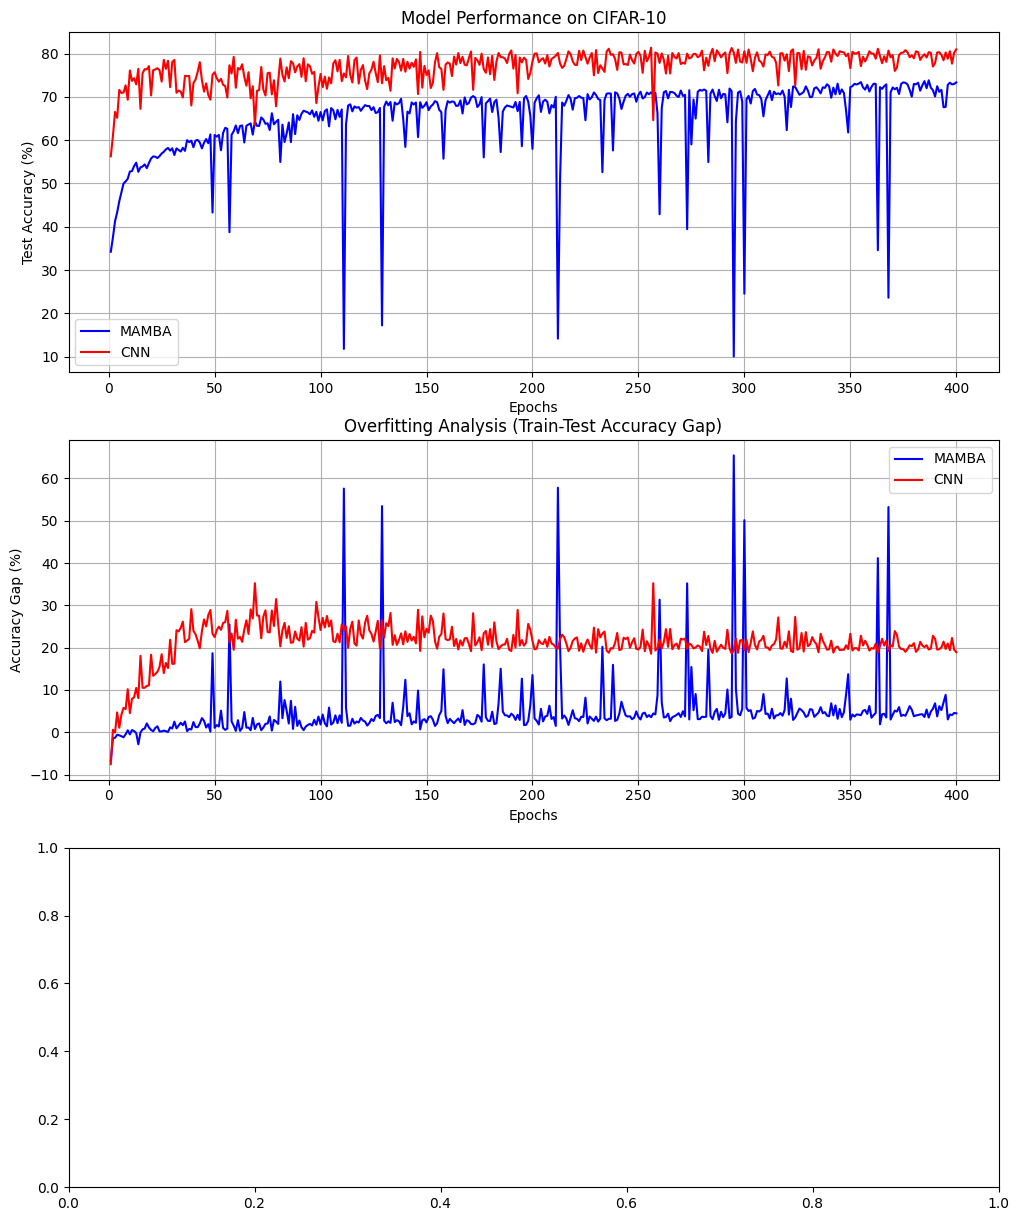

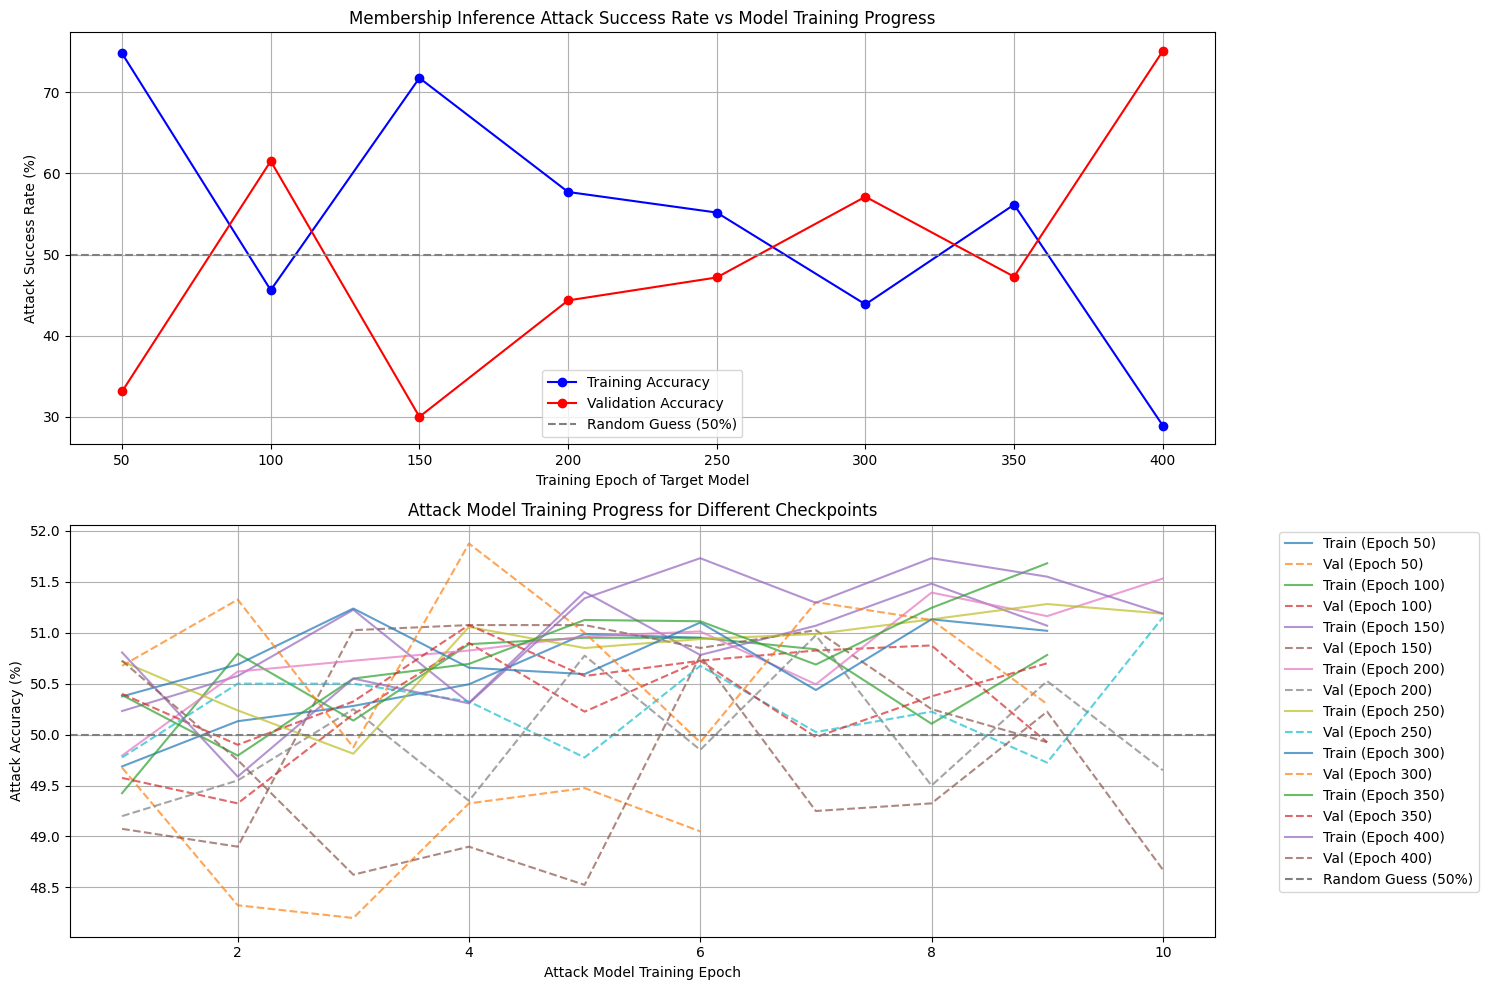


Summary of Results:
  Checkpoint    |    Train Acc    |     Val Acc     |       Vulnerability      
--------------------------------------------------------------------------------
Epoch    50    |     74.80    % |     33.11    % |           High           
Epoch   100    |     45.61    % |     61.52    % |            Low           
Epoch   150    |     71.78    % |     29.98    % |           High           
Epoch   200    |     57.71    % |     44.34    % |           High           
Epoch   250    |     55.18    % |     47.17    % |         Moderate         
Epoch   300    |     43.85    % |     57.13    % |            Low           
Epoch   350    |     56.15    % |     47.27    % |         Moderate         
Epoch   400    |     28.91    % |     75.10    % |            Low           

Analyzing CNN checkpoints...

Analyzing model checkpoint from epoch 50
Preparing attack data...
Processing training data...

Processing test data...

Training attack model with extended epochs...
Epoch

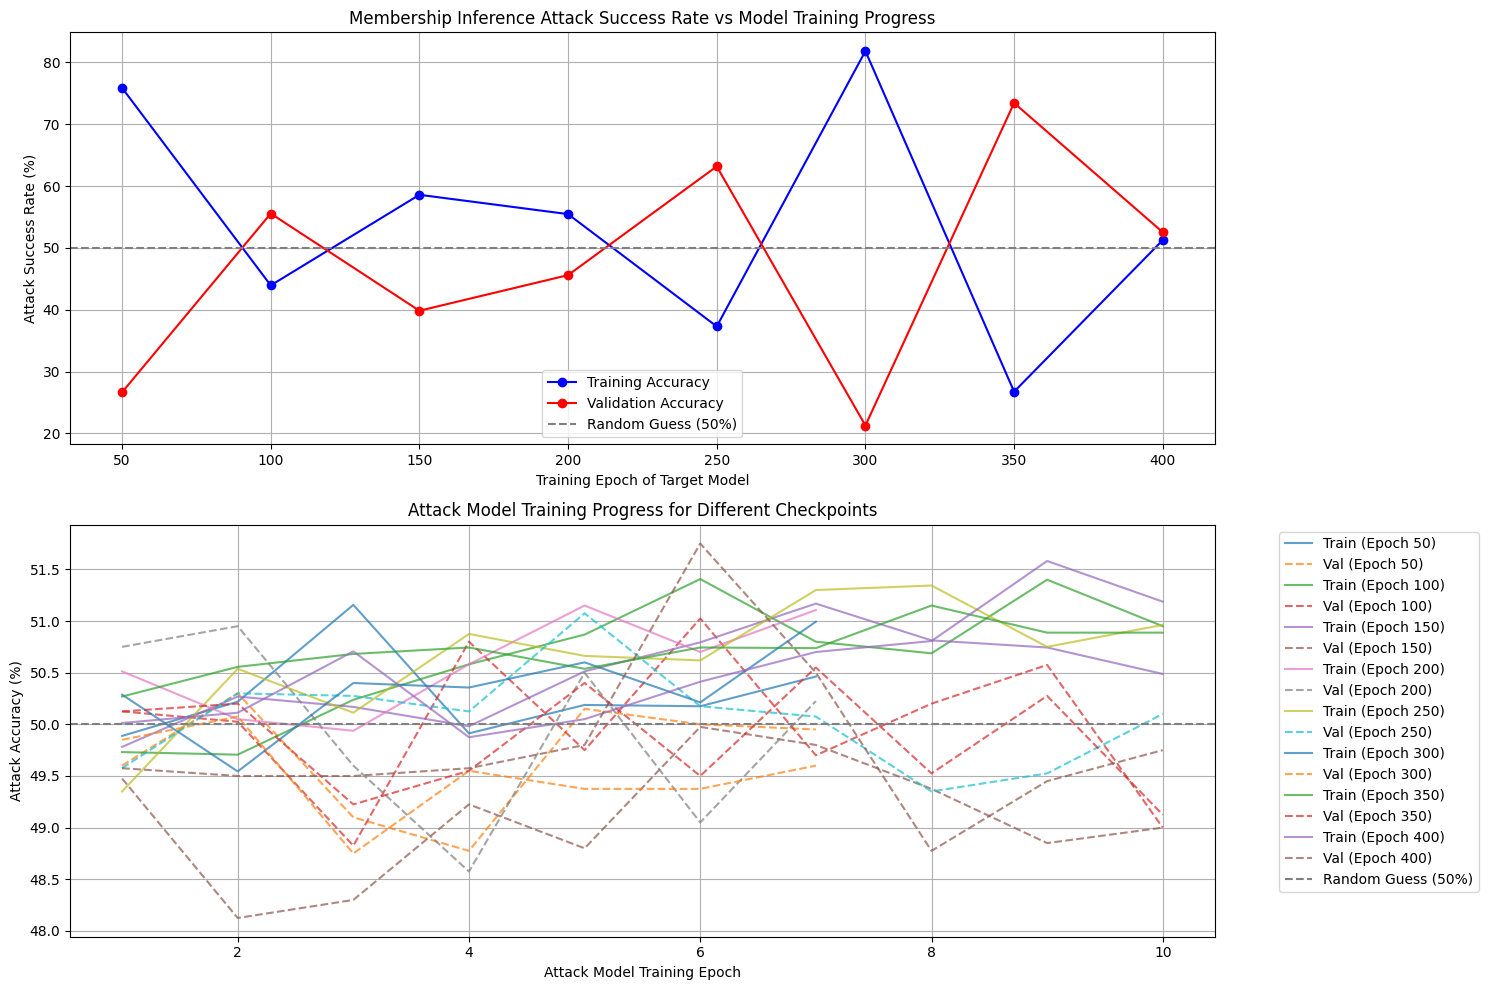


Summary of Results:
  Checkpoint    |    Train Acc    |     Val Acc     |       Vulnerability      
--------------------------------------------------------------------------------
Epoch    50    |     75.88    % |     26.66    % |           High           
Epoch   100    |     43.95    % |     55.57    % |            Low           
Epoch   150    |     58.59    % |     39.84    % |           High           
Epoch   200    |     55.47    % |     45.61    % |         Moderate         
Epoch   250    |     37.30    % |     63.18    % |            Low           
Epoch   300    |     81.84    % |     21.29    % |           High           
Epoch   350    |     26.76    % |     73.44    % |            Low           
Epoch   400    |     51.27    % |     52.54    % |            Low           


<Figure size 640x480 with 0 Axes>


Model Analysis Summary:
Final Test Accuracy:
MAMBA: 73.35%
CNN: 80.98%

Final Overfitting Gap:
MAMBA: 4.47%
CNN: 18.91%

Final Attack Success Rates:
MAMBA: 52.00%
CNN: 51.90%


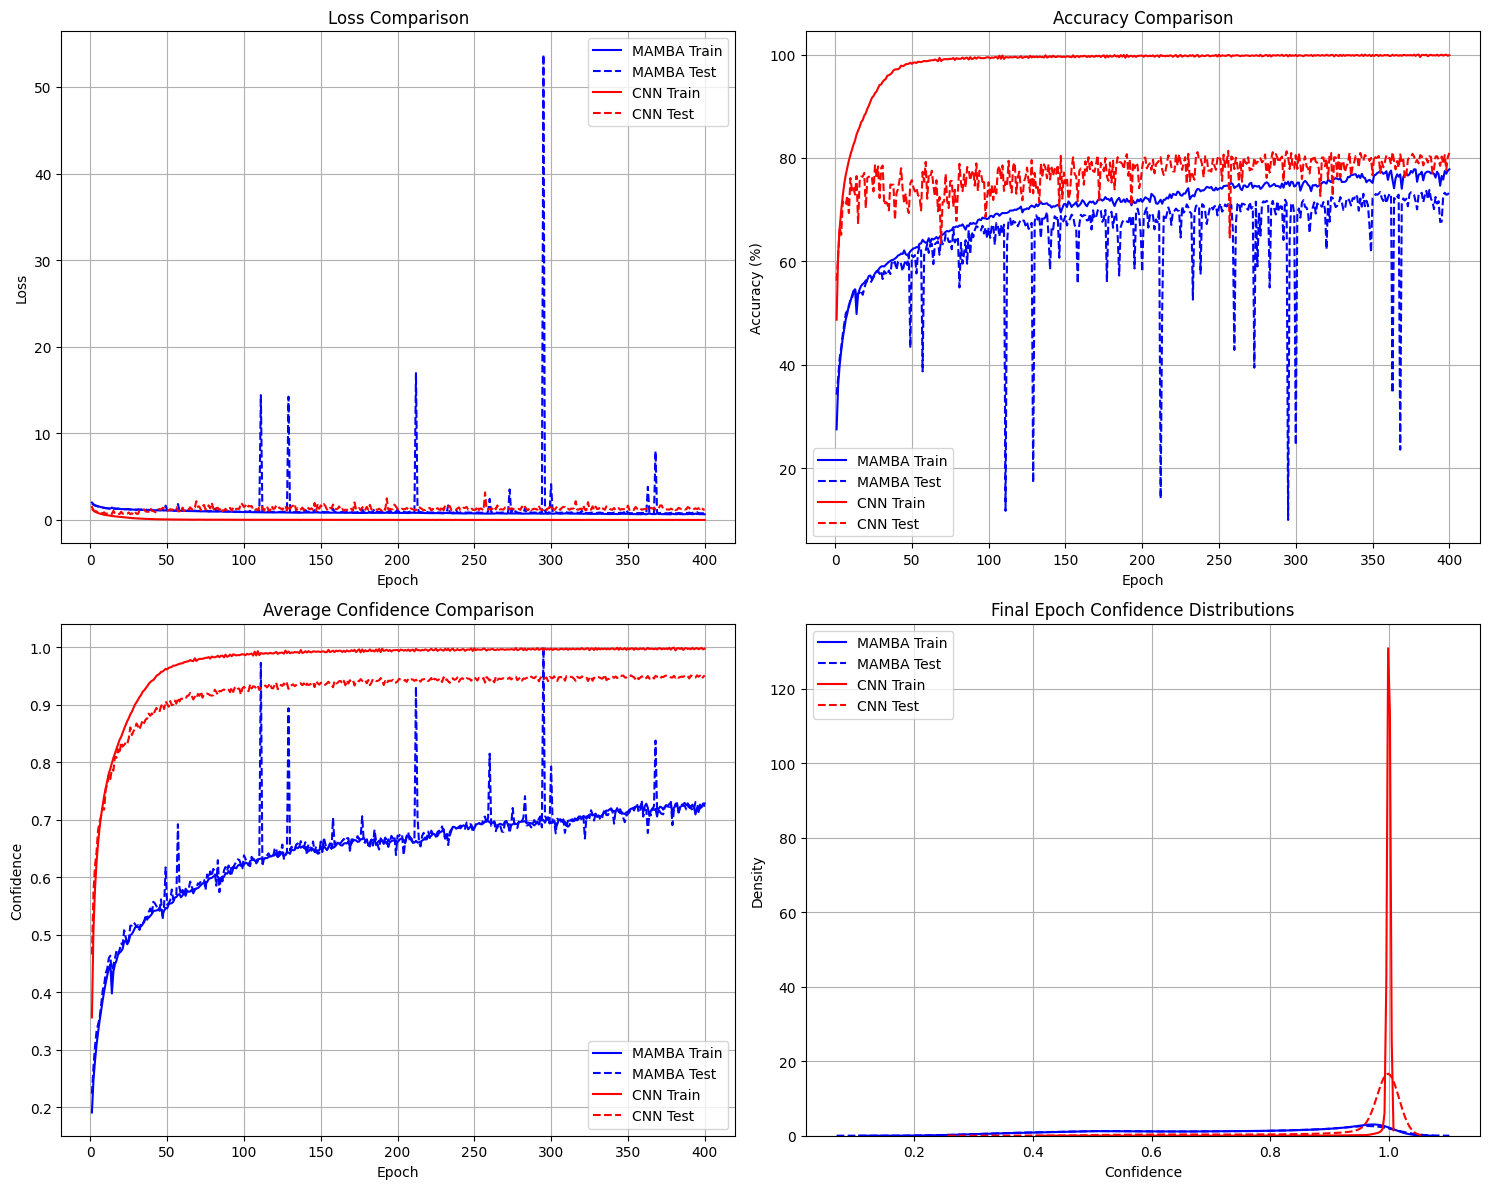

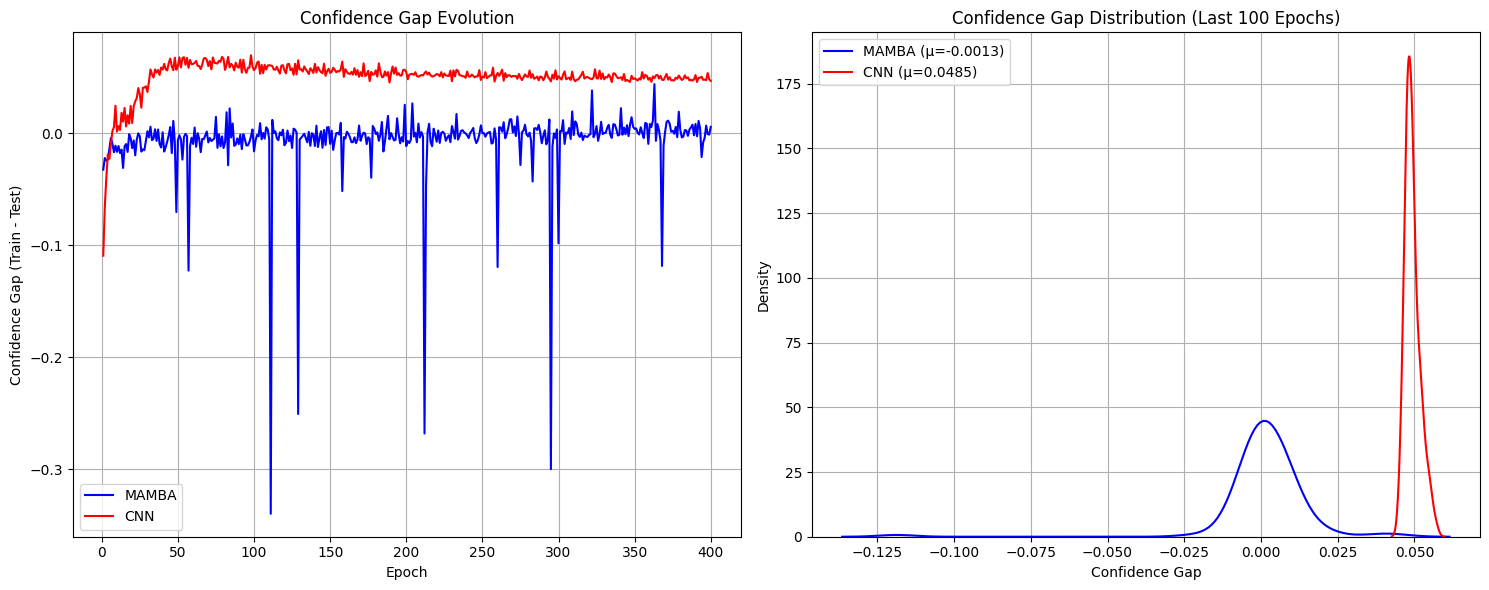

In [15]:
# Run the analysis
results = analyze_models(mamba_model, smaller_cnn_model, train_loader, test_loader)

# Generate the full report with all plots
report = generate_comparison_report()

# Compare

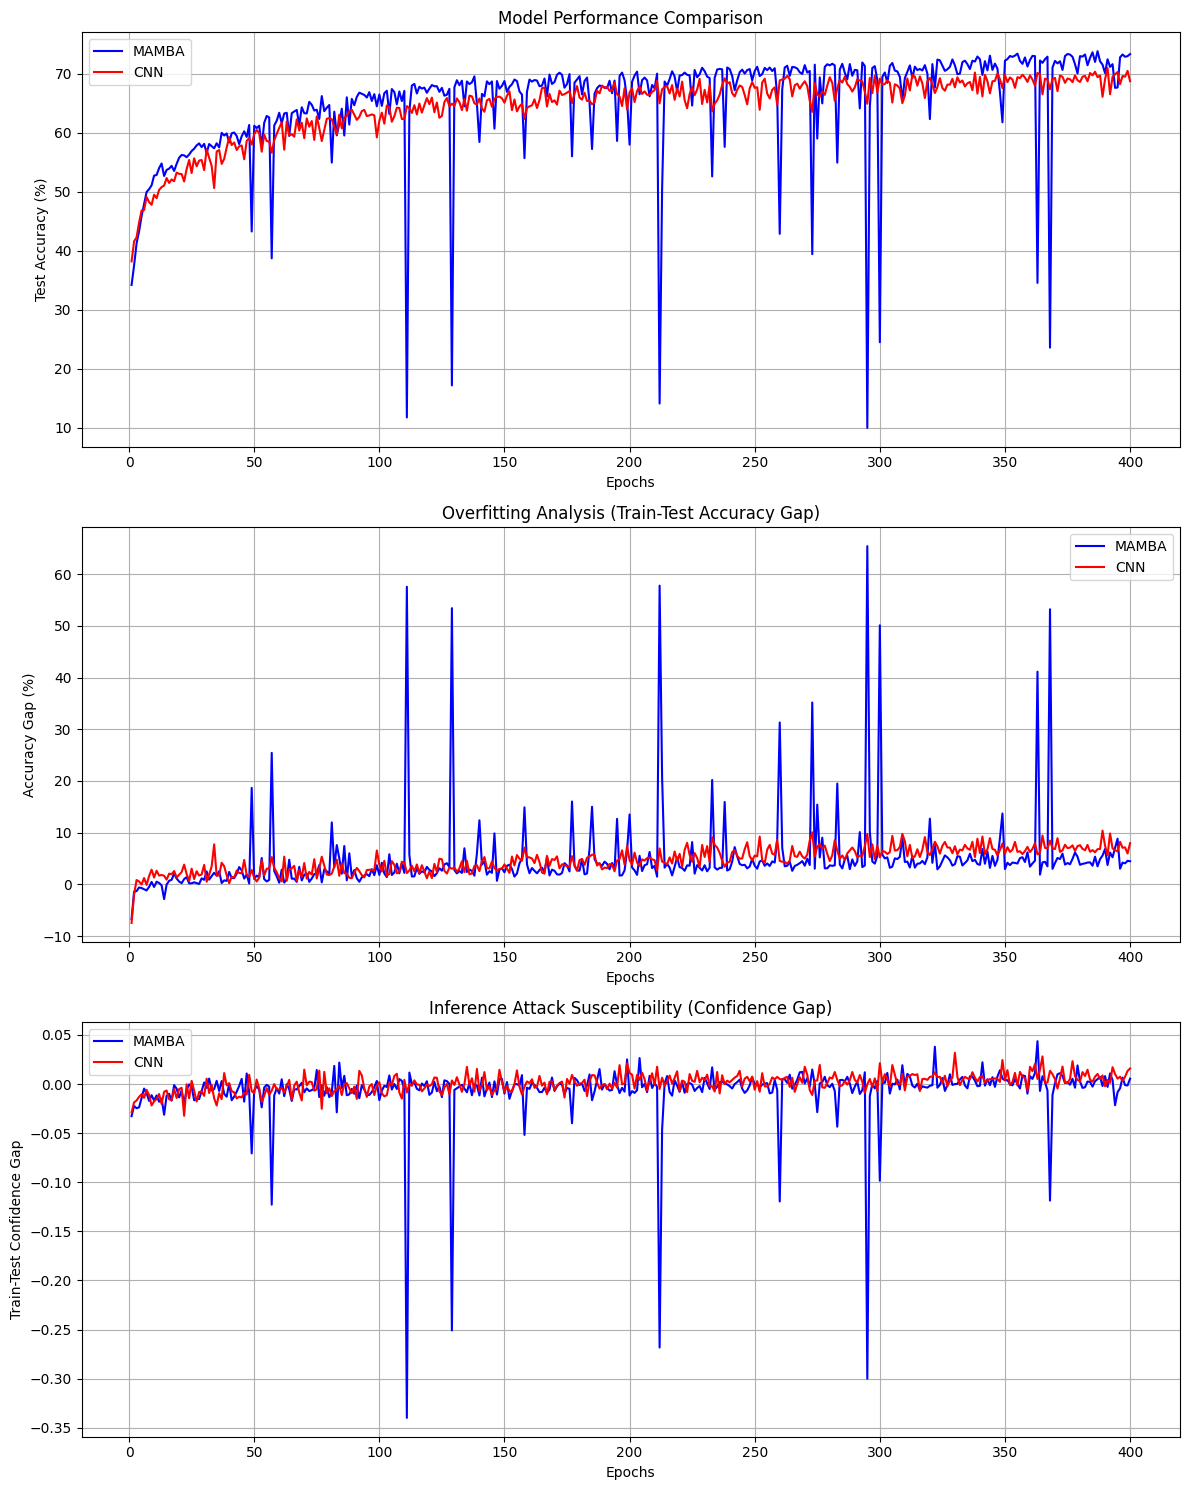


Summary Statistics:
Final Test Accuracy:
MAMBA: 73.35%
CNN: 68.75%

Final Overfitting Gap:
MAMBA: 4.47%
CNN: 7.95%

Final Inference Attack Susceptibility (Confidence Gap):
MAMBA: 0.0055
CNN: 0.0159


In [8]:
def load_metrics(model_type):
    """Load training metrics from JSON file"""
    if model_type.lower() == 'mamba':
        path = 'model_checkpoints_extended/training_metrics.json'
    else:  # CNN
        path = 'smaller_cnn_checkpoints/training_metrics.json'
    
    with open(path, 'r') as f:
        return json.load(f)

def create_comparison_plots():
    # Load metrics for both models
    mamba_metrics = load_metrics('mamba')
    cnn_metrics = load_metrics('smaller_cnn')
    
    # Create figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))
    
    # Get epochs range
    epochs = range(1, min(len(mamba_metrics['test_accuracies']), 
                         len(cnn_metrics['test_accuracies'])) + 1)
    
    # 1. Model Performance Plot (Test Accuracy)
    ax1.plot(epochs, mamba_metrics['test_accuracies'], 'b-', label='MAMBA')
    ax1.plot(epochs, cnn_metrics['test_accuracies'], 'r-', label='CNN')
    ax1.set_title('Model Performance Comparison')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Test Accuracy (%)')
    ax1.legend()
    ax1.grid(True)
    
    # 2. Overfitting Plot (Train-Test Accuracy Gap)
    mamba_overfit = [train - test for train, test in 
                     zip(mamba_metrics['train_accuracies'], mamba_metrics['test_accuracies'])]
    cnn_overfit = [train - test for train, test in 
                   zip(cnn_metrics['train_accuracies'], cnn_metrics['test_accuracies'])]
    
    ax2.plot(epochs, mamba_overfit, 'b-', label='MAMBA')
    ax2.plot(epochs, cnn_overfit, 'r-', label='CNN')
    ax2.set_title('Overfitting Analysis (Train-Test Accuracy Gap)')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy Gap (%)')
    ax2.legend()
    ax2.grid(True)
    
    # 3. Inference Attack Susceptibility (based on confidence gap)
    mamba_susceptibility = [train - test for train, test in 
                           zip(mamba_metrics['train_confidences'], mamba_metrics['test_confidences'])]
    cnn_susceptibility = [train - test for train, test in 
                         zip(cnn_metrics['train_confidences'], cnn_metrics['test_confidences'])]
    
    ax3.plot(epochs, mamba_susceptibility, 'b-', label='MAMBA')
    ax3.plot(epochs, cnn_susceptibility, 'r-', label='CNN')
    ax3.set_title('Inference Attack Susceptibility (Confidence Gap)')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Train-Test Confidence Gap')
    ax3.legend()
    ax3.grid(True)
    
    plt.tight_layout()
    plt.savefig('model_comparison_analysis.png')
    plt.show()
    
    # Print summary statistics
    print("\nSummary Statistics:")
    print("="*50)
    print("Final Test Accuracy:")
    print(f"MAMBA: {mamba_metrics['test_accuracies'][-1]:.2f}%")
    print(f"CNN: {cnn_metrics['test_accuracies'][-1]:.2f}%")
    
    print("\nFinal Overfitting Gap:")
    print(f"MAMBA: {mamba_overfit[-1]:.2f}%")
    print(f"CNN: {cnn_overfit[-1]:.2f}%")
    
    print("\nFinal Inference Attack Susceptibility (Confidence Gap):")
    print(f"MAMBA: {mamba_susceptibility[-1]:.4f}")
    print(f"CNN: {cnn_susceptibility[-1]:.4f}")

# Create the plots
create_comparison_plots()